In [ ]:
from bs4 import BeautifulSoup
from pathlib import Path
import pandas as pd
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
import sys

# Add the 'code' directory to sys.path
project_path = Path(
    '/home/ec2-user/SageMaker/david/tdm-sentiment/'
)
data_path = project_path / 'data/'
data_sample = Path('/home/ec2-user/SageMaker/data/')
sample_name = 'lda_sample' #  StartupSentiment  'USATodayDavid' 'ChicagoTribune' 'TheWashingtonPostDavid' Newyork20042023' LosAngelesTimesDavid 
sys.path.append(str(project_path / 'code'))

# Import custom modules
from get_data.tdm_parser.tdm_parser import TdmXmlParser

def read_file_names_in_chunks(input_file, chunk_size):
    with open(f'{input_file}.txt', 'r') as f:
        chunk = []
        for i, line in enumerate(f, 1):
            file_name = line.strip()
            if file_name:
                chunk.append(file_name)
            if i % chunk_size == 0:
                yield chunk
                chunk = []
        if chunk:
            yield chunk

def xml_to_df(file_path):
    parser = TdmXmlParser()
    soup = parser.get_xml_soup(file_path)
    PROPERTY_TAGS = [
        'GOID', 'SortTitle', 'NumericDate', 'DocSection', 'mstar', 
        'GenSubjTerm', 'StartPage', 'is_economic', 'bert_sentiment', 'WordCount'
    ] 
    PROPERTY_NAMES = [
        'GOID', 'Publisher', 'Date', 'Section', 'Type', 
        'Tags', 'Page', 'is_economic', 'bert_sentiment', 'WordCount'
    ]
    content_dict = parser.get_xml_to_dict(
        soup, property_tags=PROPERTY_TAGS, property_names=PROPERTY_NAMES
    )
    df = pd.DataFrame([content_dict])
    return df

# Initialize variables
data_path = project_path / 'data/'
chunk_size = 1000 
data_chunks = []


file_names_path = data_path / 'file_names' / sample_name #'economic_dataset_file_names' #TODO


for i, file_chunk in enumerate(read_file_names_in_chunks(file_names_path, chunk_size)):
    chunk_paths = [data_sample / file_name for file_name in file_chunk]
    
    # Process files in parallel with a progress bar
    with tqdm(total=len(chunk_paths), desc=f"Processing chunk {i+1}") as pbar:
        results = Parallel(n_jobs=6, backend='threading')(
            delayed(xml_to_df)(path) for path in chunk_paths 
        )
        pbar.update(len(chunk_paths)) 
    
    # Concatenate results
    if results:
        print(results[:2]) #TODO
        data = pd.concat(results, ignore_index=True)
        data_chunks.append(data)  # Append the resulting DataFrame to the list
        
        
# Concatenate all DataFrame chunks into one DataFrame after the loop
data = pd.concat(data_chunks, ignore_index=True)
print(data.head())

In [ ]:
!nvidia-smi

In [5]:
data.head()

""
0
1
2
3
4


In [40]:
import nltk
from pathlib import Path
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

# Define the path to your NLTK data directory
project_path = Path('/home/ec2-user/SageMaker/david/tdm-sentiment/')
nltk_data_path = project_path / 'code/nltk_data/corpora/'

# Ensure the nltk_data path is added as a string
nltk.data.path.append(str(nltk_data_path))

# Verify the existence of WordNet files
wordnet_path = nltk_data_path / 'wordnet'
if not wordnet_path.exists():
    raise FileNotFoundError(f"WordNet data not found at {wordnet_path}. Please ensure the WordNet corpus is downloaded.")

# Force nltk to treat all paths as strings
nltk.data.path = [str(path) for path in nltk.data.path]

# Initialize the Lemmatizer
lemmatizer = WordNetLemmatizer()

# Test WordNet access
try:
    synonyms = wordnet.synsets('run')
    print(f"Synonyms for 'run': {[syn.lemma_names() for syn in synonyms[:5]]}")
except Exception as e:
    print(f"Error accessing WordNet: {e}")

# Define the stopwords path
stopwords_path = nltk_data_path / 'stopwords/english'

# Function to load stopwords
def load_stopwords(base_path, relative_path):
    file_path = base_path / relative_path
    if file_path.exists():
        return set(file_path.read_text().splitlines())
    else:
        raise FileNotFoundError(f"Stopwords file not found at {file_path}")

# Load the stopwords
try:
    stop_words = load_stopwords(project_path, stopwords_path)
    print(f"Stopwords loaded successfully: {list(stop_words)[:10]}")  # Print the first 10 stopwords as a check
except FileNotFoundError as e:
    print(e)


Synonyms for 'run': [['run', 'tally'], ['test', 'trial', 'run'], ['footrace', 'foot_race', 'run'], ['streak', 'run'], ['run', 'running', 'running_play', 'running_game']]
Stopwords loaded successfully: ['these', 'its', "didn't", 'he', 'couldn', 'yourselves', 'rd', 'and', 'has', 'your']


In [42]:
from nltk.stem import WordNetLemmatizer

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

from pathlib import Path

# Define the path to your stopwords file
project_path = Path('/home/ec2-user/SageMaker/david/tdm-sentiment/')
stopwords_path = 'code/nltk_data/corpora/stopwords/english'

# Function to load stopwords
def load_stopwords(base_path, relative_path):
    file_path = base_path / relative_path
    if file_path.exists():
        return set(file_path.read_text().splitlines())
    else:
        raise FileNotFoundError(f"Stopwords file not found at {file_path}")

# Load the stopwords
stop_words = load_stopwords(project_path, stopwords_path)

# Define the preprocessing function with lemmatization
def preprocess_text_with_lemmatization(text_list, stop_words):
    if isinstance(text_list, list):
        text = ' '.join(text_list)
    else:
        return ''
    
    text = text.lower()
    tokens = text.split()
    tokens = [
        lemmatizer.lemmatize(word) 
        for word in tokens if word.isalpha() and word not in stop_words
    ]
    return ' '.join(tokens)


data['processed'] = data['Text'].apply(lambda x: preprocess_text_with_lemmatization(x, stop_words))



In [43]:
from sklearn.feature_extraction.text import CountVectorizer

# Create the DTM
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(data['processed'])
vocab = vectorizer.get_feature_names_out()

print("Vocabulary size:", len(vocab))
print("Sample vocabulary:", vocab[:20])


Vocabulary size: 20114
Sample vocabulary: ['aa' 'aaa' 'aac' 'aapi' 'aaron' 'aarp' 'ab' 'aba' 'abandon' 'abandoned'
 'abandoning' 'abated' 'abatement' 'abbas' 'abbey' 'abbot' 'abbott'
 'abbreviated' 'abby' 'abc']


In [44]:
from sklearn.decomposition import LatentDirichletAllocation

# Train the LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=0)  # Adjust 'n_components' for the number of topics
lda.fit(dtm)

# Display the topics
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx}: {[vocab[i] for i in topic.argsort()[-10:]]}")

Topic 0: ['product', 'team', 'deal', 'game', 'million', 'year', 'make', 'time', 'company', 'new']
Topic 1: ['want', 'city', 'make', 'year', 'million', 'time', 'business', 'people', 'company', 'new']
Topic 2: ['officer', 'los', 'official', 'county', 'people', 'city', 'stolen', 'property', 'police', 'june']
Topic 3: ['market', 'price', 'million', 'school', 'rate', 'company', 'home', 'year', 'percent', 'new']
Topic 4: ['law', 'official', 'year', 'health', 'million', 'tax', 'government', 'new', 'federal', 'state']


Preprocessing text data...
Creating document-term matrix...
Fitting LDA model...

Top words per topic (n=10):
Topic 1: city, new, home, area, year, building, project, people, los, time
Topic 2: block, pm, aug, vehicle, june, property, stolen, occurred, theft, ave
Topic 3: company, year, million, percent, market, stock, billion, share, price, sale
Topic 4: school, student, chicago, university, child, year, job, college, business, president
Topic 5: year, bank, rate, money, fund, percent, people, pay, credit, make
Topic 6: state, tax, year, plan, million, board, county, federal, district, new
Topic 7: state, case, official, health, people, court, department, government, year, law
Topic 8: ct, st, lane, corp, home, way, pl, jr, michael, john
Topic 9: game, team, player, season, league, sport, million, food, nfl, photo
Topic 10: time, new, company, car, people, make, store, service, day, use

Assigning topics to documents...

DataFrame with assigned topics:
                                

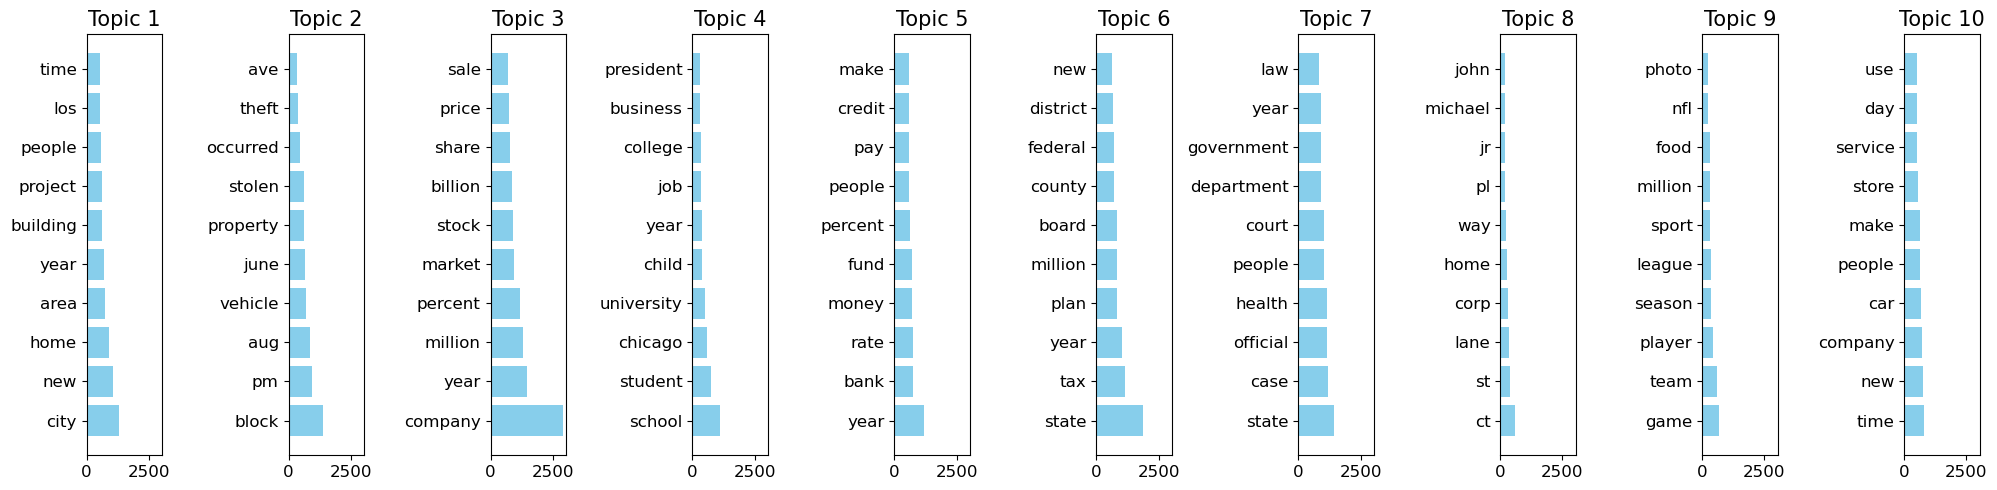

Word cloud for Topic 1 saved to plots/word_clouds/wordcloud_topic_1.png
Word cloud for Topic 2 saved to plots/word_clouds/wordcloud_topic_2.png
Word cloud for Topic 3 saved to plots/word_clouds/wordcloud_topic_3.png
Word cloud for Topic 4 saved to plots/word_clouds/wordcloud_topic_4.png
Word cloud for Topic 5 saved to plots/word_clouds/wordcloud_topic_5.png
Word cloud for Topic 6 saved to plots/word_clouds/wordcloud_topic_6.png
Word cloud for Topic 7 saved to plots/word_clouds/wordcloud_topic_7.png
Word cloud for Topic 8 saved to plots/word_clouds/wordcloud_topic_8.png
Word cloud for Topic 9 saved to plots/word_clouds/wordcloud_topic_9.png
Word cloud for Topic 10 saved to plots/word_clouds/wordcloud_topic_10.png


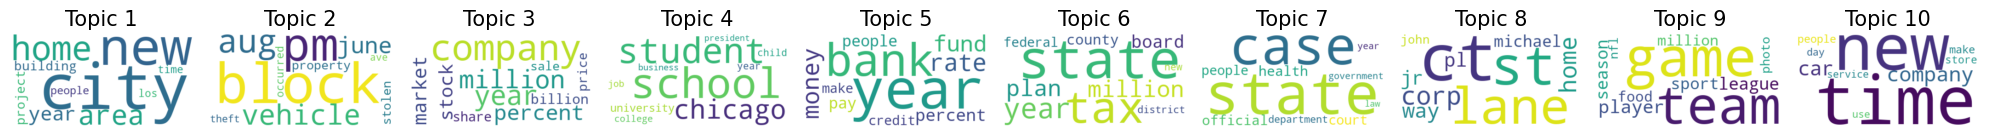

Heatmap saved to plots/heatmaps/topic_distribution_heatmap.png


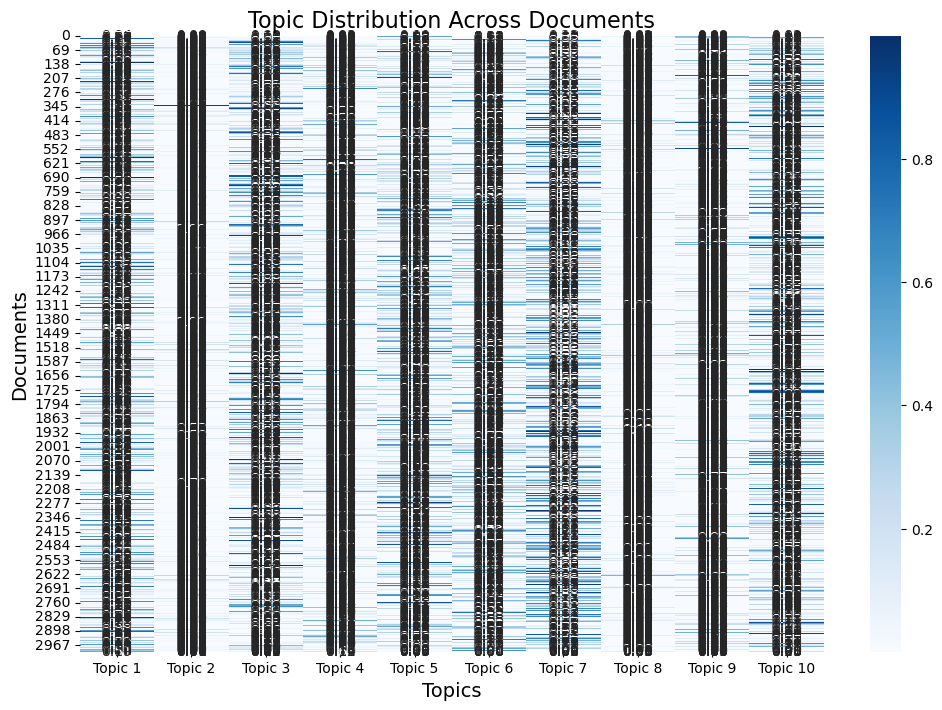

In [47]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import os
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Download necessary NLTK data files (only needed once)
#from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def preprocess_text(text):
    """
    Preprocess the input text by:
    - Lowercasing
    - Removing punctuation and numbers
    - Tokenizing
    - Removing stopwords
    - Lemmatizing
    """
    # Initialize lemmatizer and stopwords
    lemmatizer = WordNetLemmatizer()
    
    # Lowercase the text
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Tokenize the text
    tokens = text.split()
    
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # Join tokens back to string
    return ' '.join(tokens)

def create_directories(base_dir='plots'):
    """
    Create directories for saving plots.
    
    Parameters:
        base_dir (str): Base directory name for plots.
        
    Returns:
        dict: Dictionary containing paths to subdirectories.
    """
    subdirs = {
        'bar_charts': os.path.join(base_dir, 'bar_charts'),
        'word_clouds': os.path.join(base_dir, 'word_clouds'),
        'heatmaps': os.path.join(base_dir, 'heatmaps')
    }
    
    for subdir in subdirs.values():
        os.makedirs(subdir, exist_ok=True)
    
    return subdirs

def perform_lda(df, text_column='Text', n_topics=5, max_iter=10, random_state=42):
    """
    Perform LDA on the specified text column of the DataFrame.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing the text data.
        text_column (str): Name of the column containing text data.
        n_topics (int): Number of topics to extract.
        max_iter (int): Maximum number of iterations for the LDA algorithm.
        random_state (int): Random state for reproducibility.
        
    Returns:
        lda_model: Trained LDA model.
        vectorizer: CountVectorizer fitted on the text data.
        topic_words: List of words for each topic.
        df: DataFrame with an additional 'Topic' column.
        doc_topic_dist (numpy.ndarray): Topic distribution for each document.
    """
    # Check if text_column exists
    if text_column not in df.columns:
        raise ValueError(f"Column '{text_column}' not found in the DataFrame.")
    
    # Preprocess the text data
    print("Preprocessing text data...")
    df['processed_text'] = df[text_column].astype(str).apply(preprocess_text)
    
    # Create a document-term matrix
    print("Creating document-term matrix...")
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    dtm = vectorizer.fit_transform(df['processed_text'])
    
    # Check if DTM is empty
    if dtm.shape[1] == 0:
        raise ValueError("The document-term matrix is empty. Adjust 'max_df' and 'min_df' parameters.")
    
    # Fit the LDA model
    print("Fitting LDA model...")
    lda = LatentDirichletAllocation(n_components=n_topics, max_iter=max_iter,
                                    random_state=random_state, learning_method='batch')
    lda.fit(dtm)
    
    # Display the topics
    print(f"\nTop words per topic (n={n_topics}):")
    feature_names = vectorizer.get_feature_names_out()
    topic_words = []
    for topic_idx, topic in enumerate(lda.components_):
        top_indices = topic.argsort()[:-11:-1]  # Top 10 words
        top_words = [feature_names[i] for i in top_indices]
        topic_words.append(top_words)
        print(f"Topic {topic_idx +1}: " + ", ".join(top_words))
    
    # Assign topics to documents
    print("\nAssigning topics to documents...")
    doc_topic_dist = lda.transform(dtm)
    df['Topic'] = doc_topic_dist.argmax(axis=1) +1  # Adding 1 for readability
    
    return lda, vectorizer, topic_words, df, doc_topic_dist

def plot_top_words_per_topic(lda_model, vectorizer, subdirs, n_top_words=10, save=True):
    """
    Plot the top words for each topic as a bar chart and save the plots.
    
    Parameters:
        lda_model: Trained LDA model.
        vectorizer: Fitted CountVectorizer.
        subdirs (dict): Dictionary containing paths to subdirectories.
        n_top_words (int): Number of top words to display per topic.
        save (bool): Whether to save the plots.
    """
    feature_names = vectorizer.get_feature_names_out()
    n_topics = lda_model.n_components
    fig, axes = plt.subplots(1, n_topics, figsize=(20, 5), sharex=True)
    
    if n_topics ==1:
        axes = [axes]
    
    for topic_idx, ax in enumerate(axes):
        top_indices = lda_model.components_[topic_idx].argsort()[:-n_top_words -1:-1]
        top_words = [feature_names[i] for i in top_indices]
        top_weights = lda_model.components_[topic_idx][top_indices]
        
        ax.barh(top_words[::-1], top_weights[::-1], color='skyblue')
        ax.set_title(f"Topic {topic_idx +1}", fontdict={'fontsize': 15})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=12)
    
    plt.tight_layout()
    
    if save:
        filename = os.path.join(subdirs['bar_charts'], f"top_words_per_topic.png")
        plt.savefig(filename, dpi=300)
        print(f"Bar charts saved to {filename}")
    
    plt.show()

def plot_wordclouds(topic_words, lda_model, vectorizer, subdirs, n_top_words=10, save=True):
    """
    Generate and display word clouds for each topic and save the plots.
    
    Parameters:
        topic_words (list of lists): List containing lists of top words per topic.
        lda_model: Trained LDA model.
        vectorizer: Fitted CountVectorizer.
        subdirs (dict): Dictionary containing paths to subdirectories.
        n_top_words (int): Number of top words to include in the word cloud.
        save (bool): Whether to save the plots.
    """
    n_topics = len(topic_words)
    fig, axes = plt.subplots(1, n_topics, figsize=(20, 5))
    
    if n_topics ==1:
        axes = [axes]
    
    for idx, (words, ax) in enumerate(zip(topic_words, axes)):
        # Get the weights of the top words
        feature_names = vectorizer.get_feature_names_out()
        topic = lda_model.components_[idx]
        top_indices = topic.argsort()[:-n_top_words -1:-1]
        top_words = [feature_names[i] for i in top_indices]
        top_weights = topic[top_indices]
        word_freq = {word: weight for word, weight in zip(top_words, top_weights)}
        
        wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(word_freq)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f"Topic {idx +1}", fontsize=15)
        ax.axis('off')
        
        if save:
            filename = os.path.join(subdirs['word_clouds'], f"wordcloud_topic_{idx +1}.png")
            wordcloud.to_file(filename)
            print(f"Word cloud for Topic {idx +1} saved to {filename}")
    
    plt.tight_layout()
    plt.show()

def plot_topic_distribution(doc_topic_dist, subdirs, n_topics=5, save=True):
    """
    Plot a heatmap showing the distribution of topics across documents and save the plot.
    
    Parameters:
        doc_topic_dist (numpy.ndarray): Array containing topic distributions for each document.
        subdirs (dict): Dictionary containing paths to subdirectories.
        n_topics (int): Number of topics.
        save (bool): Whether to save the plot.
    """
    # Create a DataFrame for the heatmap
    topic_columns = [f"Topic {i+1}" for i in range(n_topics)]
    df_topic_dist = pd.DataFrame(doc_topic_dist, columns=topic_columns)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(df_topic_dist, cmap='Blues', cbar=True, annot=True, fmt=".2f")
    plt.title('Topic Distribution Across Documents', fontsize=16)
    plt.xlabel('Topics', fontsize=14)
    plt.ylabel('Documents', fontsize=14)
    
    if save:
        filename = os.path.join(subdirs['heatmaps'], "topic_distribution_heatmap.png")
        plt.savefig(filename, dpi=300)
        print(f"Heatmap saved to {filename}")
    
    plt.show()

def plot_interactive_top_words(lda_model, vectorizer, n_top_words=10, save=False, save_path=None):
    """
    (Optional) Plot interactive bar charts for top words per topic using Plotly.
    This function is optional since it involves additional dependencies.
    
    Parameters:
        lda_model: Trained LDA model.
        vectorizer: Fitted CountVectorizer.
        n_top_words (int): Number of top words to display per topic.
        save (bool): Whether to save the interactive plots as HTML files.
        save_path (str): Directory path to save interactive plots.
    """
    try:
        import plotly.graph_objects as go
    except ImportError:
        print("Plotly is not installed. Skipping interactive plots.")
        return
    
    if save and save_path:
        os.makedirs(save_path, exist_ok=True)
    
    feature_names = vectorizer.get_feature_names_out()
    n_topics = lda_model.n_components
    
    for topic_idx, topic in enumerate(lda_model.components_):
        top_indices = topic.argsort()[:-n_top_words -1:-1]
        top_words = [feature_names[i] for i in top_indices]
        top_weights = topic[top_indices]
        
        fig = go.Figure([go.Bar(
            x=top_weights[::-1],
            y=top_words[::-1],
            orientation='h'
        )])
        
        fig.update_layout(
            title=f"Topic {topic_idx +1} Top Words",
            xaxis_title="Weight",
            yaxis_title="Word",
            yaxis=dict(autorange="reversed"),
            template="plotly_white"
        )
        
        if save and save_path:
            filename = os.path.join(save_path, f"interactive_top_words_topic_{topic_idx +1}.html")
            fig.write_html(filename)
            print(f"Interactive bar chart for Topic {topic_idx +1} saved to {filename}")
        
        fig.show()

def main():
    # Create directories for saving plots
    subdirs = create_directories(base_dir='plots')
    
    df = pd.DataFrame(data)
    
    # Perform LDA
    lda_model, vectorizer, topics, df_with_topics, doc_topic_dist = perform_lda(
        df, text_column='Text', n_topics=10, max_iter=100, random_state=42
    )
    
    # Display the DataFrame with assigned topics
    print("\nDataFrame with assigned topics:")
    print(df_with_topics)
    
    # Visualization 1: Bar Charts of Top Words per Topic
    plot_top_words_per_topic(lda_model, vectorizer, subdirs, n_top_words=10, save=True)
    
    # Visualization 2: Word Clouds for Each Topic
    plot_wordclouds(topics, lda_model, vectorizer, subdirs, n_top_words=10, save=True)
    
    # Visualization 3: Topic Distribution Across Documents
    plot_topic_distribution(doc_topic_dist, subdirs, n_topics=lda_model.n_components, save=True)
    
    # (Optional) Visualization 4: Interactive Bar Charts with Plotly
    # Uncomment the following lines if you have Plotly installed and want interactive plots
    # plot_interactive_top_words(lda_model, vectorizer, n_top_words=10, save=True, save_path='plots/interactive_plots')
    
if __name__ == "__main__":
    main()